In [1]:
import pandas as pd
import datetime                                        # To handle dates
import calendar                                        # To get month
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics                      # To get regression metrics
import scipy as sp
import time                                            # To do time complexity analysis
import random
import copy
import profile
import cProfile
from sklearn.cluster import KMeans                     # perform clustering operation
%matplotlib inline

In [2]:
#loading in raw data
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
train_df = pd.read_csv("train.csv")

In [3]:
#Lets see how data looks like

features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [5]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores_df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [7]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [9]:
# Creating a custom season dictionary to identify the season in each month
seasons_dict = {
    1:"Winter",
    2:"Winter",
    3:"Spring",
    4:"Spring",
    5:"Spring",
    6:"Summer",
    7:"Summer",
    8:"Summer",
    9:"Fall",
    10:"Fall",
    11:"Fall",
    12:"Winter"
}

In [10]:
# Creating the master dataset
master_df = train_df.merge(stores_df, on='Store', how='left')
master_df = master_df.merge(features_df, on=['Store', 'Date'], how='left')

In [11]:
master_df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


## Preliminary Analysis

In [12]:
d = copy.deepcopy(master_df)

d1 = d["Weekly_Sales"]

print(d["Weekly_Sales"].describe())

print("Percentile less than 3% provides only negative value : ",d["Weekly_Sales"].quantile(0.003))

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64
Percentile less than 3% provides only negative value :  -0.56


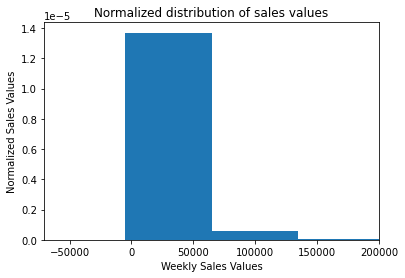

In [13]:
x = np.concatenate((d1[d["Weekly_Sales"] < 0], d1[d["Weekly_Sales"] > 0]))

plt.hist(x, density=True)

plt.xlim([-70496, 200000])
plt.xlabel('Weekly Sales Values')
plt.ylabel('Normalized Sales Values')
plt.title('Normalized distribution of sales values')
plt.show()

## Data Cleaning

In [14]:
# Filling empty markdown columns
master_df['MarkDown1'] = master_df['MarkDown1'].fillna(0)
master_df['MarkDown2'] = master_df['MarkDown2'].fillna(0)
master_df['MarkDown3'] = master_df['MarkDown3'].fillna(0)
master_df['MarkDown4'] = master_df['MarkDown4'].fillna(0)
master_df['MarkDown5'] = master_df['MarkDown5'].fillna(0)

# Cleaning holiday columns
master_df['isHoliday'] = master_df['IsHoliday_x']
master_df = master_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [15]:
# Handling Date and time
master_df['Date'] = pd.to_datetime(master_df['Date'], format='%Y-%m-%d')
master_df['Week_Number'] = master_df['Date'].dt.isocalendar().week
master_df['Quarter'] = master_df['Date'].dt.quarter
master_df['Month'] = master_df['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
master_df['Season'] = (master_df['Date'].apply(lambda dt: (dt.month%12 + 3)//3)).map(seasons_dict)
master_df["Year"] = master_df["Date"].dt.year

## Creating lagged variables based on time

In [16]:
master_df=master_df.sort_values(by=['Store', 'Dept', 'Year', 'Week_Number'], ascending=True)    

# Previous week sales
shifted_sales = master_df.shift(1)
master_df_new_var = master_df.join(shifted_sales[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year']], rsuffix='_Lag')
master_df_new_var.loc[(master_df_new_var.Dept != master_df_new_var.Dept_Lag) |  (master_df_new_var.Store != master_df_new_var.Store_Lag), 'Weekly_Sales_Lag'] = -2

# Previous month sales
#shifted_sales = master_df.shift(4)
#master_df_new_var = master_df_new_var.join(shifted_sales[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year']], rsuffix='_Lag2')
#master_df_new_var['Monthly_Sales_Lag'] = master_df_new_var.Week_Number_Lag2
#master_df_new_var.loc[((master_df_new_var.Week_Number - master_df_new_var.Week_Number_Lag2) != 4) , 'Monthly_Sales_Lag'] = 0
#master_df_new_var[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year', 'Weekly_Sales_Lag']]

# Average yearly sales
#my_df= master_df[['Store','Dept','Week_Number','Weekly_Sales']]
#my_df2= my_df.groupby(['Store','Dept','Week_Number']).mean()
#master_df.set_index(['Store','Dept','Week_Number'],inplace= True)
#df=master_df.join(my_df2, rsuffix='_yearly').reset_index(inplace=True)
#master_df_new_var['Yearly_Sales']=df['Weekly_Sales_yearly']

Lagged time varibles play a significant role in explaining current trends and seasonal pattern which repeat over a period of time. Furthermore lag variables capture the inherent store features which can get little tricky to zero out

## Creating dummy variables for categorical values

In [17]:
#forming categorarical variables
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Quarter'], prefix='Quarter'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Season'], prefix='Season'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Store'], prefix='Store'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Dept'], prefix='Dept'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Type'], prefix='Type'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Week_Number'], prefix='Week_Number'))

In [18]:
# Removing wrongly recorded data points
master_df_new_var = master_df_new_var.dropna()
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Week_Number'] > 4]
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Monthly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales'] > 0] #keeping points which are only positive in value for the sales

In [19]:
master_df_new_var.head(2)

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Week_Number_43,Week_Number_44,Week_Number_45,Week_Number_46,Week_Number_47,Week_Number_48,Week_Number_49,Week_Number_50,Week_Number_51,Week_Number_52
1,1,1,2010-02-12,46039.49,A,151315,38.51,2.548,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2010-02-19,41595.55,A,151315,39.93,2.514,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Creating interaction variable

In [20]:
master_df_new_var['MarkDown'] = master_df_new_var['MarkDown1'] + master_df_new_var['MarkDown2'] + master_df_new_var['MarkDown3'] + master_df_new_var['MarkDown4'] + master_df_new_var['MarkDown5']
master_df_new_var['MarkDown*Weekly_Sales_Lag'] = master_df_new_var['MarkDown']*master_df_new_var['Weekly_Sales_Lag']

We created an interaction variable as promotional offers (markdown) and weekly sales go hand in hand. They together explain the future weekly sales in a very robust fashion

## Model Building

### Dividing the dataset into test and train dataset

We will do an out of time validation. The model will be trained on first two years data and tested on the last six months data.

In [21]:
#segregating the data
data_test = master_df_new_var[master_df_new_var.Year == 2012]
data_train = master_df_new_var[master_df_new_var.Year != 2012]

## Building full model linear regression

In [22]:
features = list(master_df_new_var)
for x in ('Quarter',
 'Month',
 'Season',
 'Year',
 'Store',
 'Dept',
 'Date',
 'Type',
 'Weekly_Sales',
 'Weekly_Sales_Lag'):
    features.remove(x)
#features

In [23]:
# Writing the formula
equals_to_str = ""
for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str[:-3] 
equals_to_str_promotion = equals_to_str + "Markdown1"

In [24]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289299 entries, 1 to 421526
Columns: 215 entries, Store to MarkDown*Weekly_Sales_Lag
dtypes: UInt32(2), bool(1), datetime64[ns](1), float64(16), int64(5), object(3), uint8(187)
memory usage: 112.0+ MB


In [25]:
dtype_df = pd.DataFrame(data_train.dtypes)
dtype_df[(dtype_df[0] == 'UInt32')]

,0
Week_Number,UInt32
Week_Number_Lag,UInt32


In [26]:
data_train = data_train.astype({'Week_Number' : 'uint32'})
data_train = data_train.astype({'Week_Number_Lag' : 'uint32'})

In [27]:
result_fullmodel = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_fullmodel.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:03:25   Log-Likelihood:            -2.9899e+06
No. Observations:              289299   AIC:                         5.980e+06
Df Residuals:                  289109   BIC:                         5.982e+06
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

## Exploratory Analysis and descriptive statistics

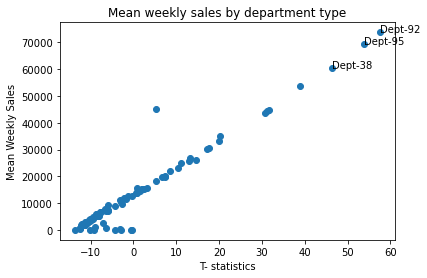

In [28]:
unique_dept_values = master_df_new_var.Dept.unique() #getting unique values of store by department type
unique_data_string = []    #creating null list
mark = []

#creating unique list containing names of department for creating labels for the graph
for counter in range(0, len(unique_dept_values)):
    if unique_dept_values[counter] == 38 or unique_dept_values[counter] == 92 or unique_dept_values[counter] == 95:
        unique_data_string.append("Dept-" + str(unique_dept_values[counter]))
        mark.append("+")
    else:
        unique_data_string.append("")
        mark.append("o")


mean_sales = []   #creating list of mean sales
for intcounter in unique_dept_values:
    mean_sales.append(data_train[data_train["Dept_" + str(intcounter)]==1]["Weekly_Sales"].mean()) #estimating mean sales for store by department type

#creating formula for regression
equals_to_str_dept = "Weekly_Sales ~ Weekly_Sales_Lag + isHoliday + Temperature + Type_A + Type_B + Type_C+ Week_Number_50 + Week_Number_51 + " 
for intcounter in range(len(unique_dept_values)):
    if intcounter != len(unique_dept_values)-1:
        equals_to_str_dept = equals_to_str_dept + "Dept_" + str(unique_dept_values[intcounter]) + " + "
    else:
        equals_to_str_dept = equals_to_str_dept + "Dept_" + str(unique_dept_values[intcounter])

#running regression with relevant variables and all the department type to calculate which department type impacts the weekly sales the most
result_with_dpt = sm.ols(formula=equals_to_str_dept, data = data_train).fit()
result_list = result_with_dpt.tvalues #calculating t value to zero in on important parameters
result_tstat = []
 
for intcounter in range(9,90):
    result_tstat.append(result_list[intcounter]) #getting t stat value for each department and store type
 
fig, ax = plt.subplots()
ax.scatter(result_tstat, mean_sales) #making a scatter plot to highlight high performing departments
plt.xlabel('T- statistics')
plt.ylabel('Mean Weekly Sales')
plt.title('Mean weekly sales by department type')

for i, txt in enumerate(unique_data_string):
    ax.annotate(txt, (result_tstat[i],mean_sales[i])) #identifying the high performing graph and labelling them

The graph here illustrates Department 38, 95 and 92 performing extra-ordinarily in terms of mean weekly sales. T-statistics are the values obtained by keeping all the departments as an independent variable in the full model and then observing the significance of these varibles in getting to the response variable (future weekly sale)

We have found out the next set of important variables. They include size, markdown and yearly lag.

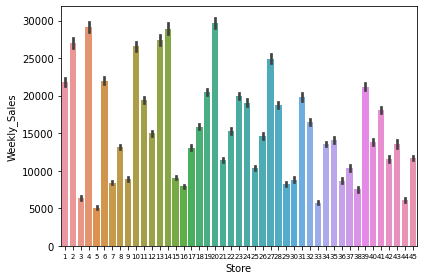

In [29]:
ax= sns.barplot(x="Store", y="Weekly_Sales",  data=master_df_new_var)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

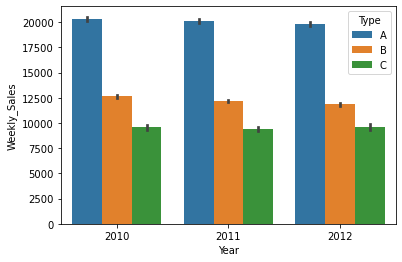

In [30]:
sns.barplot(x="Year", y="Weekly_Sales", hue="Type", data=master_df)
plt.show()

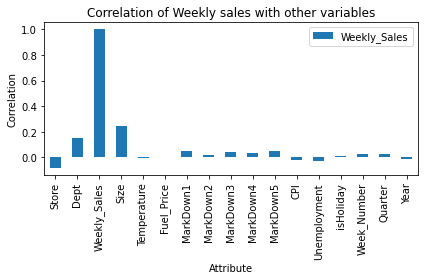

In [31]:
df_corr = master_df.corr()
ax=df_corr[['Weekly_Sales']].plot(kind='bar')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.title('Correlation of Weekly sales with other variables')
plt.tight_layout()
plt.show()

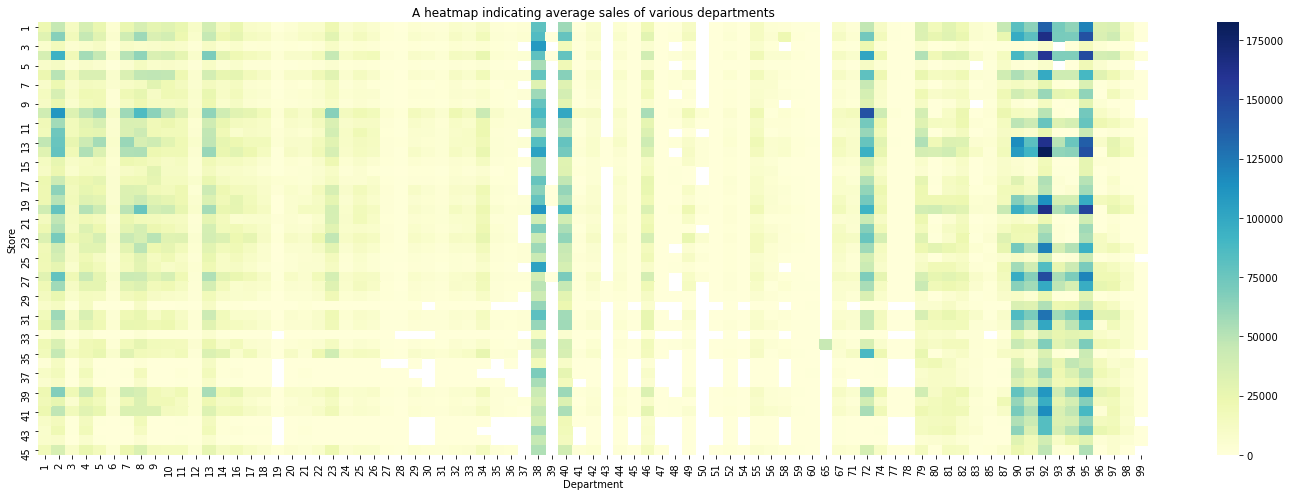

In [32]:
heat_df= master_df[['Store','Dept','Weekly_Sales']]
heat_map=heat_df.groupby(['Store','Dept']).mean()
heat_map.reset_index(inplace=True)
heat_map=heat_map.pivot('Store','Dept','Weekly_Sales')
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(heat_map, cmap="YlGnBu", ax=ax)
plt.xlabel('Department')
plt.ylabel('Store')
plt.title('A heatmap indicating average sales of various departments')
plt.tight_layout()
plt.show()

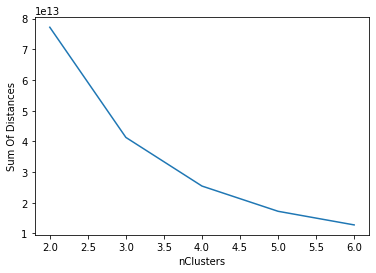

In [33]:
#function to draw pair plot
def drawpairplot(total_clusters, data, blnDraw):
    kmeans=KMeans(n_clusters=total_clusters).fit(data)
    data['Cluster']=kmeans.labels_
    if blnDraw:
        sns.pairplot(data,hue='Cluster')

df = copy.deepcopy(master_df)   #creating a copy of the data frame to not change the master data frame
df["Type"] = df['Type'].map({'A': int(0), 'B': int(1), 'C': int(2)}) #giving numberical values to different store types

nClusters = range(2,7)  #defining a range of clusters between 2 and 7
rel_cols=['Type', 'Weekly_Sales'] #defining the relevant columns in the data set on which clustering needs to run

sumDistances=[]

#calculating SSE
for n in nClusters:
    kmeans=KMeans(n_clusters=n).fit(df[rel_cols])
    sumDistances.append(kmeans.inertia_) #Proxy for SSE

# Plotting the elbow graph
plt.plot(nClusters,sumDistances,'-')
plt.xlabel('nClusters')
plt.ylabel('Sum Of Distances')
plt.show()

As we see a slight kink at cluster = 3. Assuming cluster as 3 and plotting the pair plot


<ipython-input-33-40a0a908ac1b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster']=kmeans.labels_


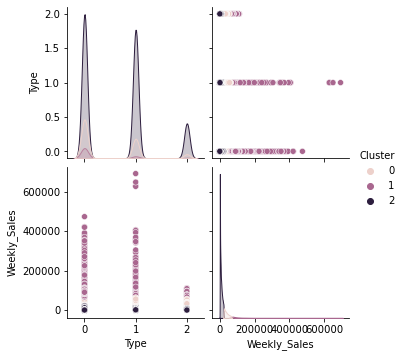

In [34]:
print("As we see a slight kink at cluster = 3. Assuming cluster as 3 and plotting the pair plot")
drawpairplot(3,df[rel_cols],True) #drawing pair plot for 3 clusters

## Variable Shortlisting based on above analysis

In [35]:
features = ['isHoliday', 'Temperature', 'Weekly_Sales_Lag']#, 'Size', 'MarkDown5', 'master_df_new_var']
features.extend(master_df_new_var.columns[master_df_new_var.columns.str.startswith('Type')])
features.remove('Type')

In [36]:
equals_to_str = ""

for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str  + 'Week_Number_50 + Week_Number_51+ Dept_95 + Dept_92+ Dept_38'
equals_to_str_withpromotion = equals_to_str  + '+ MarkDown*Weekly_Sales_Lag'

## Reduced Models

In [37]:
result_withoutpromotion = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_withoutpromotion.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 2.099e+05
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:04:17   Log-Likelihood:            -3.0104e+06
No. Observations:              289299   AIC:                         6.021e+06
Df Residuals:                  289288   BIC:                         6.021e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept 

In [38]:
result_withpromotion = sm.ols(formula=equals_to_str_withpromotion, data = data_train).fit()
print("Model 1 with Promotion \n",result_withpromotion.summary())

Model 1 with Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.822e+05
Date:                Thu, 17 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:04:17   Log-Likelihood:            -3.0052e+06
No. Observations:              289299   AIC:                         6.010e+06
Df Residuals:                  289286   BIC:                         6.010e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [39]:
data_test = pd.concat([data_test, result_withoutpromotion.predict(data_test).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_test.predicted_values_withoutpromotion, data_test.Weekly_Sales)/data_test.Weekly_Sales.median()))*100, 2), '%.(in the test dataset)')
data_train = pd.concat([data_train, result_withoutpromotion.predict(data_train).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_train.predicted_values_withoutpromotion, data_train.Weekly_Sales)/data_train.Weekly_Sales.median()))*100, 2), '%.(in the train dataset)')

The accuracy of the model is 84.56 %.(in the test dataset)
The accuracy of the model is 84.53 %.(in the train dataset)


## Result Plots

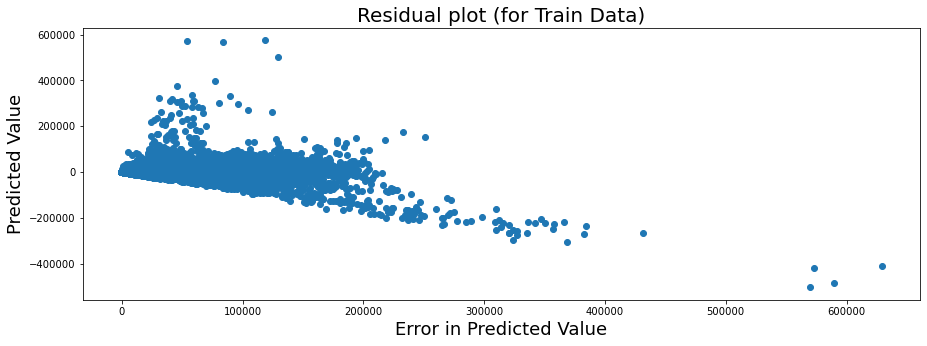

In [40]:
pred_val = result_withoutpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Residual plot (for Train Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

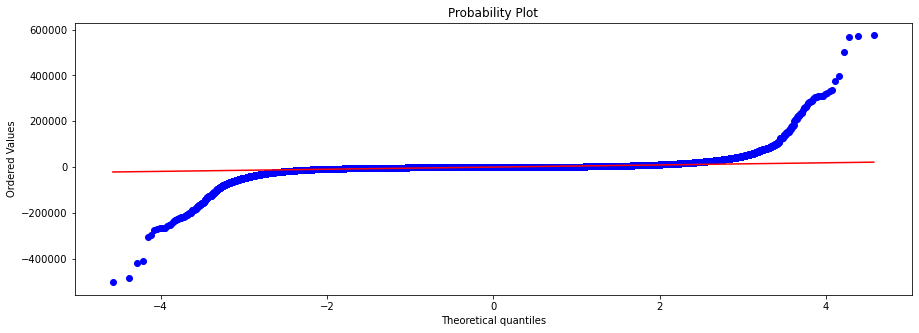

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
#r**2

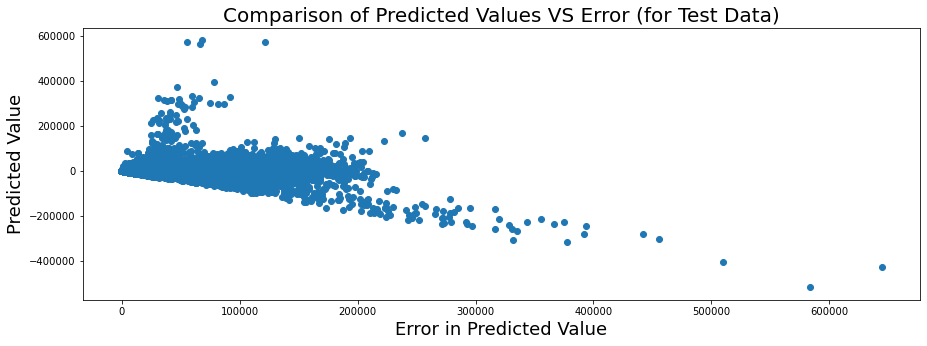

In [42]:
pred_val = result_withpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Comparison of Predicted Values VS Error (for Test Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

In [43]:
data_test["predicted_values_withoutpromotion"] = result_withoutpromotion.predict(data_test)
data_test["predicted_values_withpromotion"] = result_withoutpromotion.predict(data_test)

actual_sales = data_test.groupby("Dept").mean()["Weekly_Sales"]
predicted_sales_withoutpromotion = data_test.groupby("Dept").mean()["predicted_values_withoutpromotion"]
#data_test.to_csv("predictedvsactual.csv")


Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

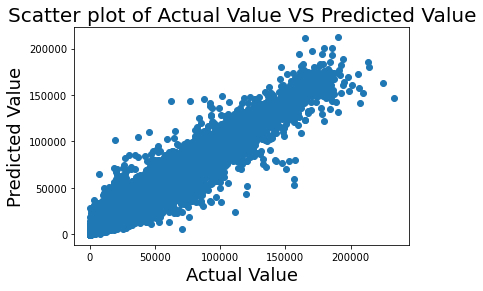

In [44]:
plt.scatter(data_test['Weekly_Sales'], data_test['predicted_values_withpromotion'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)